#Description
    Demultiplex RhizCG 150520_run1


#Setting variables

In [2]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/150520_run1/'
seqDir = '/var/seq_data/RhizCG/150520_run1/raw/'

metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_run1_e.txt'
read1_file = 'read1.fq'
read2_file = 'read2.fq'
index_read1_file = 'index1.fq'
index_read2_file = 'index2.fq'
read12_screed_file = 'pear_merged-2015-06-01.assembled.fastq_screed'

#Init

In [4]:
import os
import screed
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from ggplot import *
import re
import scipy.stats as stats

In [3]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

In [5]:
%load_ext rpy2.ipython

In [5]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gdata)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size



In [6]:
#long processessing time
os.chdir(seqDir)
screed.read_fastq_sequences(index_read1_file)
screed.read_fastq_sequences(index_read2_file)

##Checkpoint: define index screed files to skip above step

In [7]:
index_read1_screed = index_read1_file + '_screed'
index_read2_screed = index_read2_file + '_screed'

#Demultiplex

In [8]:
# rev-comp functions
def complement(seq): 
    idx = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N':'N'} 
    idx.update( {x.lower():y.lower() for x,y in idx.items()} )
    return ''.join(idx[x] for x in list(seq))

def revComp(seq):
    seq = seq[::-1]
    return complement(seq)

In [7]:
# loading/editing metadata

df_meta = pd.read_table(os.path.join(workDir,metadataFile), delimiter="\t")
df_meta.columns = ['Sample'] + list((df_meta.columns)[1:])
print df_meta.columns
zip(df_meta.fwd_barcode,df_meta.rev_barcode)

Index([u'Sample', u'Library', u'Primer_plate', u'well_ID', u'primerFR_ID_byPlate', u'primerFR_ID_total', u'barcode_ID', u'PlotID', u'Plant', u'Plot', u'Treatment', u'Rep', u'DAP', u'Sampling', u'PlantSample', u'Type', u'Grass_Broad', u'Status', u'Subfamily', u'fwd_barcode', u'rev_barcode'], dtype='object')


[('GGATATCT', 'TCGCTATA'),
 ('GATCGTGT', 'TCATAGAC'),
 ('GTCAGATA', 'TCATAGAC'),
 ('GACACCGT', 'TCGCTATA'),
 ('ATCGTACG', 'AACTCTCG'),
 ('ACTATCTG', 'AACTCTCG'),
 ('ATCGTACG', 'GTCGTAGT'),
 ('ACTATCTG', 'GTCGTAGT'),
 ('TAGCGAGT', 'AACTCTCG'),
 ('CTGCGTGT', 'AACTCTCG'),
 ('TAGCGAGT', 'GTCGTAGT'),
 ('CTGCGTGT', 'GTCGTAGT'),
 ('TCATCGAG', 'AACTCTCG'),
 ('CGTGAGTG', 'AACTCTCG'),
 ('GGATATCT', 'AACTCTCG'),
 ('GACACCGT', 'AACTCTCG'),
 ('TCATCGAG', 'GTCGTAGT'),
 ('CGTGAGTG', 'GTCGTAGT'),
 ('GGATATCT', 'GTCGTAGT'),
 ('GACACCGT', 'GTCGTAGT'),
 ('ATCGTACG', 'GGAGACTA'),
 ('ACTATCTG', 'GGAGACTA'),
 ('ATCGTACG', 'TAGCAGAC'),
 ('ACTATCTG', 'TAGCAGAC'),
 ('TAGCGAGT', 'GGAGACTA'),
 ('CTGCGTGT', 'GGAGACTA'),
 ('TCATCGAG', 'GGAGACTA'),
 ('CGTGAGTG', 'GGAGACTA'),
 ('TAGCGAGT', 'TAGCAGAC'),
 ('CTGCGTGT', 'TAGCAGAC'),
 ('GGATATCT', 'GGAGACTA'),
 ('GACACCGT', 'GGAGACTA'),
 ('TCATCGAG', 'TAGCAGAC'),
 ('CGTGAGTG', 'TAGCAGAC'),
 ('GGATATCT', 'TAGCAGAC'),
 ('ATCGTACG', 'GTCGCTCG'),
 ('ACTATCTG', 'GTCGCTCG'),
 

In [9]:
# loading/editing metadata

df_meta = pd.read_table(os.path.join(workDir,metadataFile), delimiter="\t")
df_meta.columns = ['Sample'] + list((df_meta.columns)[1:])

df_meta['Barcode_FR'] = [(revComp(y) + x).lower() for x,y \
                         in zip(df_meta.fwd_barcode,df_meta.rev_barcode)]

## format of barcode=>sample dict: [revcomp(revBarcode=read1) + fwdBarcode=read2] : sampleID
map_d = {x:y for x,y in zip(df_meta.Barcode_FR, df_meta.Sample)}

In [10]:
# loading screed databases 
os.chdir(seqDir)

ir1db = screed.ScreedDB(index_read1_screed)
ir2db = screed.ScreedDB(index_read2_screed)
amp_db = screed.ScreedDB(read12_screed_file)

In [12]:
# demultiplexing: naming reads by sample

outFile = re.sub('fastq_screed', 'dmult.fastq', read12_screed_file)

counter = 0
unassigned = 0
cnt = Counter()
outFile = os.path.join(workDir, outFile)
c = 0
with open(outFile, "w") as out:
    for rec in amp_db.itervalues():
        # debug
        #c += 1
        #if c > 10000:
        #    break
            
        index_concat = ir1db[rec["name"]]["sequence"] + ir2db[rec["name"]]["sequence"]
        
        try:
            new_name = map_d[index_concat.lower()] + "_" + str(counter) #case sensitive
        except KeyError:
            unassigned += 1
            continue
        counter += 1
        cnt[map_d[index_concat.lower()]] += 1 #case sensitive
        s, q = rec["sequence"], rec["accuracy"]
        out.write("@%s orig_name=%s\n%s\n+\n%s\n"%(new_name,rec["name"],s,q))
        
        
print "Unable to assign %s reads to samples"%unassigned

Unable to assign 1975316 reads to samples


In [ ]:
##Checkpoint: define outfile for next command without running above.

In [10]:
outFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/150520_run1/pear_merged-2015-06-01.assembled.dmult.fastq'

In [11]:
# number of sequences
n_lines = !wc -l $outFile
n_lines = int(re.sub(' .+', '', n_lines[0]))
print 'Number of sequences: {}'.format(n_lines/4)

Number of sequences: 8037686


# Stats on sequences

## Number of sequences per sample

In [12]:
# counting sequences for each sample
re_seqName = re.compile(r'_\d+ orig_name.+')

seq_cnt = dict()
with open(outFile, 'r') as fn:
    for line in fn.readlines():
        if re.search(re_seqName, line):
            sampleName = re.sub(re_seqName, '', line).rstrip().lstrip('@')
            try:
                seq_cnt[sampleName] += 1
            except KeyError:
                seq_cnt[sampleName] = 1 

In [13]:
# converting to dataframe
df_seq_cnt = pd.DataFrame(seq_cnt.items(), columns=['Sample', 'seq_count'])
df_seq_cnt

,Sample,seq_count
0,sample1-1.27_Nneg,25904
1,sample3-2.05_Nneg,61671
2,sample1-3.07_Npos,49496
3,sample5-4.27_Npos,98926
4,sample4-1.06_Nneg,68935
5,sample6-1.15_Npos,50902
6,sample5-4.08_Nneg,78741
7,sample2-3.05_Nneg,39853
8,sample3-3.07_Nneg,58372
9,sample5-1.06_Nneg,34486


In [15]:
%%R -i workDir -i metadataFile -i df_seq_cnt

myDir = paste(c(workDir, '../'), collapse='')
setwd(myDir)


df_meta = read.delim(metadataFile)
df_meta %>% head %>% print

           X..sample Library Primer_plate well_ID primerFR_ID_byPlate
1        H20_Control       1            1     G12                  95
2   Negative_Control       1            2     G11                  87
3   Positive_Control       1            2     H11                  88
4 Positive_Control_2       1            1     H12                  96
5  sample1-1.27_Nneg       1            1      A1                   1
6  sample1-1.27_Npos       1            1      B1                   2
  primerFR_ID_total barcode_ID    PlotID Plant Plot Treatment Rep DAP Sampling
1                95         95      <NA>  <NA>   NA      <NA>  NA  NA     <NA>
2               183        183      <NA>  <NA>   NA      <NA>  NA  NA     <NA>
3               184        184      <NA>  <NA>   NA      <NA>  NA  NA     <NA>
4                96         96      <NA>  <NA>   NA      <NA>  NA  NA     <NA>
5                 1          1 1.27_Nneg FAGES 1.27      Nneg   1  36  sample1
6                 2          2 1.27_

In [16]:
%%R

tbl.cnt = inner_join(df_seq_cnt, df_meta, c('Sample' = 'X..sample'))
tbl.cnt %>% head

             Sample seq_count Library Primer_plate well_ID primerFR_ID_byPlate
1 sample1-1.27_Nneg     25904       1            1      A1                   1
2 sample3-2.05_Nneg     61671       1            1     H10                  80
3 sample1-3.07_Npos     49496       1            1      D9                  68
4 sample5-4.27_Npos     98926       1            2      G9                  71
5 sample4-1.06_Nneg     68935       1            1     E11                  85
6 sample6-1.15_Npos     50902       1            2      B5                  34
  primerFR_ID_total barcode_ID    PlotID Plant Plot Treatment Rep DAP Sampling
1                 1          1 1.27_Nneg FAGES 1.27      Nneg   1  36  sample1
2                80         80 2.05_Nneg  BARE 2.05      Nneg   2  57  sample3
3                68         68 3.07_Npos  BARE 3.07      Npos   3  36  sample1
4               167        167 4.27_Npos  BARE 4.27      Npos   4  72  sample5
5                85         85 1.06_Nneg  BARE 1.06 

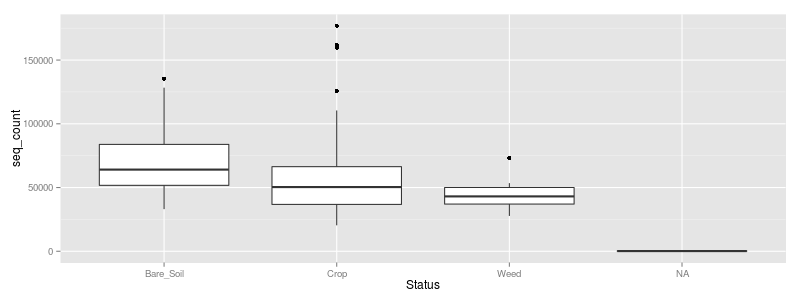

In [17]:
%%R -w 800 -h 300


ggplot(tbl.cnt, aes(Status, seq_count)) +
    geom_boxplot()